In [2]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
path = './dataset/'

In [4]:
train_data = pd.read_csv(path+'used_car_train_20200313.csv',sep = ' ')
test_data = pd.read_csv(path+'used_car_testB_20200421.csv',sep = ' ')
df = pd.concat([train_data,test_data],ignore_index=True)
print(train_data.shape)
print(test_data.shape)
print(df.shape)
df

(150000, 31)
(50000, 30)
(200000, 31)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,249995,111443,20041005,4.0,4,0.0,NaN,1.0,150,15.0,...,0.263668,0.000292,0.141804,0.076393,0.039272,2.072901,-2.531869,1.716978,-1.063437,0.326587
199996,249996,152834,20130409,65.0,1,0.0,0.0,0.0,179,4.0,...,0.255310,0.000991,0.155868,0.108425,0.067841,1.358504,-3.290295,4.269809,0.140524,0.556221
199997,249997,132531,20041211,4.0,4,0.0,0.0,1.0,147,12.5,...,0.262933,0.000318,0.141872,0.071968,0.042966,2.165658,-2.417885,1.370612,-1.073133,0.270602
199998,249998,143405,20020702,40.0,1,4.0,0.0,1.0,176,15.0,...,0.282106,0.000023,0.067483,0.067526,0.009006,2.030114,-2.939244,0.569078,-1.718245,0.316379


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             200000 non-null  int64  
 1   name               200000 non-null  int64  
 2   regDate            200000 non-null  int64  
 3   model              199999 non-null  float64
 4   brand              200000 non-null  int64  
 5   bodyType           193990 non-null  float64
 6   fuelType           188396 non-null  float64
 7   gearbox            192051 non-null  float64
 8   power              200000 non-null  int64  
 9   kilometer          200000 non-null  float64
 10  notRepairedDamage  200000 non-null  object 
 11  regionCode         200000 non-null  int64  
 12  seller             200000 non-null  int64  
 13  offerType          200000 non-null  int64  
 14  creatDate          200000 non-null  int64  
 15  price              150000 non-null  float64
 16  v_

In [6]:
temp = df.isnull().sum()
temp[temp > 0]

model           1
bodyType     6010
fuelType    11604
gearbox      7949
price       50000
dtype: int64

<AxesSubplot:>

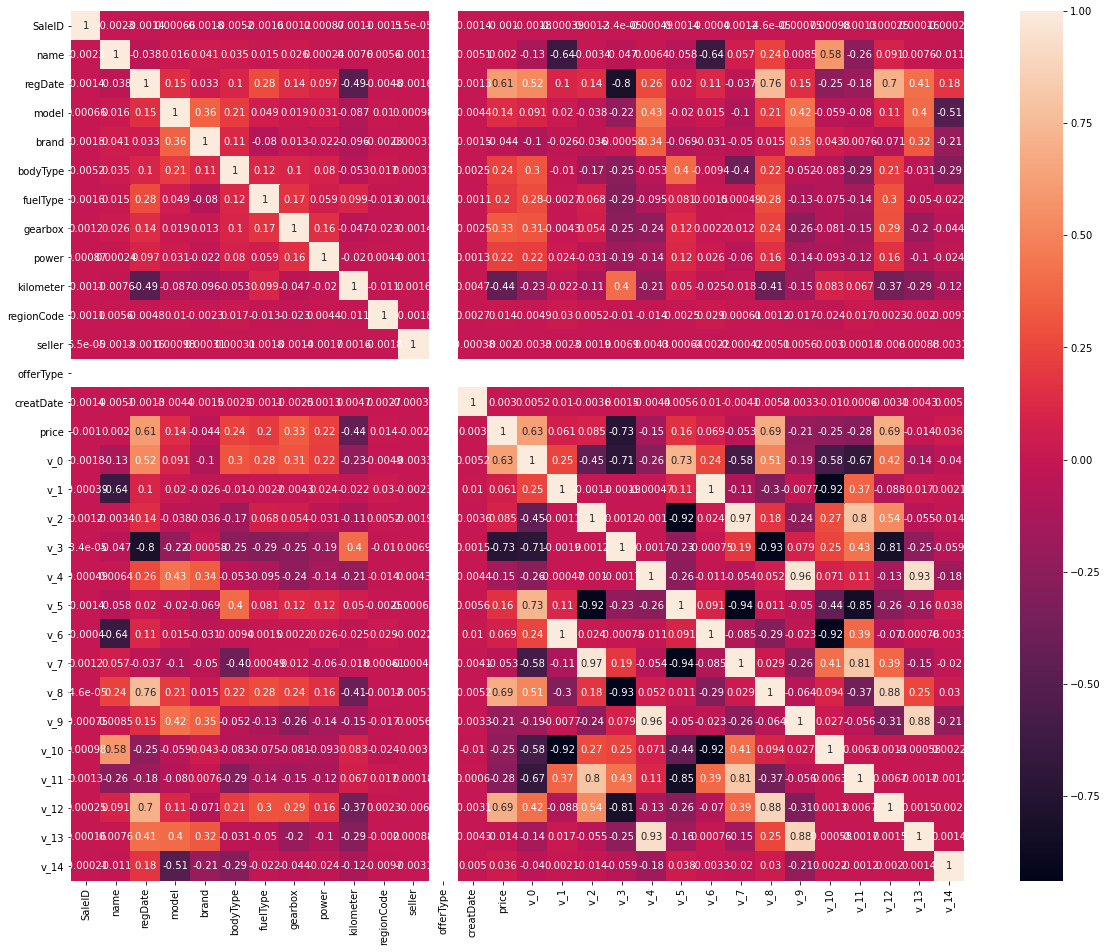

In [7]:
corr = df[df['price'].notnull()].corr()
plt.figure(figsize=(20,16))
sns.heatmap(corr,annot=True)

In [8]:
del df['offerType']
del df['SaleID']
del df['name']

In [9]:
#和price相关性较高的几个feature,后续若有其他的则再添加
corr = df[df['price'].notnull()].corr()
feature_cols = [i for i in corr[abs(corr['price'])>0.3]['price'].index if i not in ['price']]
feature_cols

['regDate', 'gearbox', 'kilometer', 'v_0', 'v_3', 'v_8', 'v_12']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   regDate            200000 non-null  int64  
 1   model              199999 non-null  float64
 2   brand              200000 non-null  int64  
 3   bodyType           193990 non-null  float64
 4   fuelType           188396 non-null  float64
 5   gearbox            192051 non-null  float64
 6   power              200000 non-null  int64  
 7   kilometer          200000 non-null  float64
 8   notRepairedDamage  200000 non-null  object 
 9   regionCode         200000 non-null  int64  
 10  seller             200000 non-null  int64  
 11  creatDate          200000 non-null  int64  
 12  price              150000 non-null  float64
 13  v_0                200000 non-null  float64
 14  v_1                200000 non-null  float64
 15  v_2                200000 non-null  float64
 16  v_

In [11]:
df['notRepairedDamage'].value_counts()

0.0    148585
-       32393
1.0     19022
Name: notRepairedDamage, dtype: int64

In [12]:
#处理异常值
df['notRepairedDamage'].replace('-','0.0',inplace=True)
df['notRepairedDamage'] = df['notRepairedDamage'].astype('float64')
df['power'][df['power']>600] = 600
df['power'].max()

600

In [13]:
# #补充缺失值 model bodyType fuelType gearbox
for cols in ['model','bodyType','fuelType','gearbox']:
    df[cols] = df[cols].fillna(0.0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   regDate            200000 non-null  int64  
 1   model              200000 non-null  float64
 2   brand              200000 non-null  int64  
 3   bodyType           200000 non-null  float64
 4   fuelType           200000 non-null  float64
 5   gearbox            200000 non-null  float64
 6   power              200000 non-null  int64  
 7   kilometer          200000 non-null  float64
 8   notRepairedDamage  200000 non-null  float64
 9   regionCode         200000 non-null  int64  
 10  seller             200000 non-null  int64  
 11  creatDate          200000 non-null  int64  
 12  price              150000 non-null  float64
 13  v_0                200000 non-null  float64
 14  v_1                200000 non-null  float64
 15  v_2                200000 non-null  float64
 16  v_

In [14]:
##检查多样性，异常值，类似power最大600，但有616个不同值，就不合理，需处理
for i in df.columns:
    print(i,df[i].count(),df[i].nunique())

regDate 200000 3898
model 200000 248
brand 200000 40
bodyType 200000 8
fuelType 200000 7
gearbox 200000 2
power 200000 458
kilometer 200000 13
notRepairedDamage 200000 2
regionCode 200000 8010
seller 200000 2
creatDate 200000 106
price 150000 3763
v_0 200000 189740
v_1 200000 189741
v_2 200000 189740
v_3 200000 189741
v_4 200000 189741
v_5 200000 183941
v_6 200000 144599
v_7 200000 182791
v_8 200000 187726
v_9 200000 185291
v_10 200000 189740
v_11 200000 189740
v_12 200000 189740
v_13 200000 189741
v_14 200000 189741


In [15]:
feature_cols

['regDate', 'gearbox', 'kilometer', 'v_0', 'v_3', 'v_8', 'v_12']

In [16]:
# #date 处理
def to_year(x):
    return int(str(x)[0:4])
df['car_used_year'] = df['creatDate'].apply(lambda x:to_year(x)) - df['regDate'].apply(lambda x: to_year(x))
df['car_used_year']

0         12
1         13
2         12
3         20
4          4
          ..
199995    12
199996     3
199997    12
199998    14
199999     7
Name: car_used_year, Length: 200000, dtype: int64

In [17]:
#test 测试一下groupby效果
df.groupby('car_used_year',as_index=False)['price'].agg({'car_used_year'+'_sum':'sum'})

,car_used_year,car_used_year_sum
0,0,0.0
1,1,33902502.0
2,2,47794293.0
3,3,50997830.0
4,4,69209489.0
5,5,80519034.0
6,6,71977297.0
7,7,73548446.0
8,8,69886677.0
9,9,64234659.0


In [18]:
#添加可用特征值
feature_cols.extend(['brand'])
feature_cols.extend(['bodyType'])
feature_cols.extend(['car_used_year'])
feature_cols.remove('regDate')
feature_cols

['gearbox',
 'kilometer',
 'v_0',
 'v_3',
 'v_8',
 'v_12',
 'brand',
 'bodyType',
 'car_used_year']

In [19]:
df['power'].value_counts()

0      17219
75     12784
150     8717
60      8521
140     7879
       ...  
9          1
520        1
407        1
587        1
383        1
Name: power, Length: 458, dtype: int64

In [20]:
# #将部分连续值转化为离散值
# from sklearn.preprocessing import KBinsDiscretizer as KBD
# KBD_power = KBD(n_bins=20, encode='ordinal', strategy='kmeans').fit(df['power'].values.reshape(-1,1))
# df['power'] = KBD_power.transform(df['power'].values.reshape(-1,1))

# KBD_year = KBD(n_bins=5, encode='ordinal', strategy='kmeans').fit(df['car_used_year'].values.reshape(-1,1))
# df['car_used_year'] = KBD_year.transform(df['car_used_year'].values.reshape(-1,1))

# KBD_kilometer = KBD(n_bins=5, encode='ordinal', strategy='kmeans').fit(df['kilometer'].values.reshape(-1,1))
# df['kilometer'] = KBD_year.transform(df['kilometer'].values.reshape(-1,1))


In [21]:
feature_cols

['gearbox',
 'kilometer',
 'v_0',
 'v_3',
 'v_8',
 'v_12',
 'brand',
 'bodyType',
 'car_used_year']

In [22]:
#测试 组合 price + brand等
col_tmp = ['brand','car_used_year','kilometer','fuelType','bodyType','model']
for col in col_tmp:
    t = df.groupby(col,as_index=False)['price'].agg(
    {col+'_count':'count',col+'_max':'max',col+'_min':'min',col+'_sum':'sum',col+'_mean':'mean',col+'_median':'median',col+'_std':'std'})
    df = pd.merge(df,t,on=col,how='left')

In [23]:
print(df.columns)

Index(['regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power',
       'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'creatDate',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'car_used_year',
       'brand_count', 'brand_max', 'brand_min', 'brand_sum', 'brand_mean',
       'brand_median', 'brand_std', 'car_used_year_count', 'car_used_year_max',
       'car_used_year_min', 'car_used_year_sum', 'car_used_year_mean',
       'car_used_year_median', 'car_used_year_std', 'kilometer_count',
       'kilometer_max', 'kilometer_min', 'kilometer_sum', 'kilometer_mean',
       'kilometer_median', 'kilometer_std', 'fuelType_count', 'fuelType_max',
       'fuelType_min', 'fuelType_sum', 'fuelType_mean', 'fuelType_median',
       'fuelType_std', 'bodyType_count', 'bodyType_max', 'bodyType_min',
       'bodyType_sum', 'bodyType_mean', 'bodyType_median', 'bodyType_std',
       'model_coun

In [24]:
df['kilometer']

0         12.5
1         15.0
2         12.5
3         15.0
4          5.0
          ... 
199995    15.0
199996     4.0
199997    12.5
199998    15.0
199999     3.0
Name: kilometer, Length: 200000, dtype: float64

In [25]:
#把另外 v0 v3 v8 v12做特征
num_cols = [0,3,8,12]
for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'*'+str(j)]=df['v_'+str(i)]*df['v_'+str(j)]
        
for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'+'+str(j)]=df['v_'+str(i)]+df['v_'+str(j)]


for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'-'+str(j)]=df['v_'+str(i)]-df['v_'+str(j)]


for i in num_cols:
    df['new'+str(i)+'*year']=df['v_'+str(i)] * df['car_used_year']

In [26]:
print(df.columns)

Index(['regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power',
       'kilometer', 'notRepairedDamage', 'regionCode',
       ...
       'new8-8', 'new8-12', 'new12-0', 'new12-3', 'new12-8', 'new12-12',
       'new0*year', 'new3*year', 'new8*year', 'new12*year'],
      dtype='object', length=123)


In [26]:
# #model lgb
# '''
# lgb test result

# rate  estimators  result
# 0.01  10000  549    
# 0.01  5000   580
# 0.05  5000   527
# 0.1   8000   508    
# 0.15  10000  518
# 0.05  8000   526

# power，kilo car_used_year分箱
# 0.05  5000   606
# power      分箱10  20
# 0.05  5000   532  529
# '''
# # clf = lgb.LGBMRegressor (
# #             num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='regression',
# #             max_depth=-1, learning_rate=0.1, min_child_samples=3, random_state=2021,
# #             n_estimators=8000, subsample=1, colsample_bytree=1,
# #         )
# # clf = lgb.LGBMRegressor (
# #             reg_alpha=0.25, reg_lambda=0.25, objective='regression_l1',
# #             boosting_type= 'gbdt',lambda_l2 = 2,bagging_fraction = 0.8,bagging_freq = 1,
# #             feature_fraction = 0.8,min_child_samples = 20, num_leaves = 31,
# #             max_depth=-1, learning_rate=0.1, random_state=2021,
# #             n_estimators=8000, subsample=1, colsample_bytree=1,
# #         )

# clf = lgb.LGBMRegressor (
#         boosting_type='gbdt',
#         num_leaves=31,
#         max_depth=-1,
#         lambda_l2=2,  
#         min_data_in_leaf=20,
#         objective='regression_l1',
#         learning_rate=0.02,
#         min_child_samples=20,
#         feature_fraction=0.8,
#         bagging_freq=1,
#         bagging_fraction=0.8,
#         bagging_seed=11,
#         metric='mae',
#         n_estimators=8000,
#         )

In [27]:
# #cross validation
# from sklearn.model_selection import KFold
# skf = KFold(n_splits=5, random_state=2021, shuffle=True)

# lgb_mae = 0
# sub_lgb = 0
# for i,(trn_idx,val_idx) in enumerate(skf.split(X_train,Y_train)):
#     print('---------- {} fold ---------'.format(i+1))
#     trn_x,trn_y = X_train.iloc[trn_idx].reset_index(drop=True),Y_train[trn_idx]
#     val_x,val_y = X_train.iloc[val_idx].reset_index(drop=True),Y_train[val_idx]
#     clf.fit(trn_x,trn_y,eval_metric='mae')
#     sub_lgb +=clf.predict(X_test) / skf.n_splits
#     val_lgb = clf.predict(val_x)
#     print('val mae:',mean_absolute_error(val_y,val_lgb))
#     lgb_mae += mean_absolute_error(val_y,val_lgb)/skf.n_splits
# print('MAE OF VAL WITH LGB:',lgb_mae)

In [28]:
# '''
# model: catboost
# '''
# import catboost as cbt

# cb_params = {
#     'n_estimators': 3000,
#     'loss_function': 'MAE',
#     'eval_metric': 'MAE',
#     'learning_rate': 0.1,
#     'depth': 6,
# #     'use_best_model': True,
#     'subsample': 0.6,
#     'bootstrap_type': 'Bernoulli',
#     'reg_lambda': 3,
#     'one_hot_max_size': 2,
# }
# cbt_model = cbt.CatBoostRegressor(**cb_params)

In [29]:
# #cross validation
# from sklearn.model_selection import KFold
# skf = KFold(n_splits=5, random_state=2021, shuffle=True)

# cbt_mae = 0
# sub_cbt = 0
# for i,(trn_idx,val_idx) in enumerate(skf.split(X_train,Y_train)):
#     print('---------- {} fold ---------'.format(i+1))
#     trn_x,trn_y = X_train.iloc[trn_idx].reset_index(drop=True),Y_train[trn_idx]
#     val_x,val_y = X_train.iloc[val_idx].reset_index(drop=True),Y_train[val_idx]
#     cbt_model.fit(trn_x,trn_y)
#     sub_cbt +=cbt_model.predict(X_test) / skf.n_splits
#     val_cbt = cbt_model.predict(val_x)
#     print('val mae:',mean_absolute_error(val_y,val_cbt))
#     cbt_mae += mean_absolute_error(val_y,val_cbt)/skf.n_splits
# print('MAE OF VAL WITH CBT:',cbt_mae)

In [30]:
# '''
# model:xgb

# xgb test result

# 0.05  3000  540
# 0.1   3000  540
# '''
# xlf = xgb.XGBRegressor(
#             max_depth=6, learning_rate=0.1, n_estimators=500, 
#             objective='reg:linear',# tree_method='gpu_hist', 
#             subsample=0.8, colsample_bytree=0.7, 
#             min_child_samples=3, eval_metric='mae', reg_lambda=0.5
#         )

In [31]:
# #cross validation
# from sklearn.model_selection import KFold
# skf = KFold(n_splits=5, random_state=2021, shuffle=True)

# xgb_mae = 0
# sub_xgb = 0
# for i,(trn_idx,val_idx) in enumerate(skf.split(X_train,Y_train)):
#     print('---------- {} fold ---------'.format(i+1))
#     trn_x,trn_y = X_train.iloc[trn_idx].reset_index(drop=True),Y_train[trn_idx]
#     val_x,val_y = X_train.iloc[val_idx].reset_index(drop=True),Y_train[val_idx]
#     xlf.fit(trn_x,trn_y,eval_metric='mae')
#     sub_xgb +=xlf.predict(X_test) / skf.n_splits
#     val_xgb = xlf.predict(val_x)
#     print('val mae:',mean_absolute_error(val_y,val_xgb))
#     xgb_mae += mean_absolute_error(val_y,val_xgb)/skf.n_splits
# print('MAE OF VAL WITH XGB:',xgb_mae)

In [32]:
# #lgb and cbt 融合

# val_weighted = (1-lgb_mae/(lgb_mae+cbt_mae))*val_lgb+(1-cbt_mae/(lgb_mae+cbt_mae))*val_cbt
# val_weighted[val_weighted<0]=10 
# print('MAE OF WEIGHTED:',mean_absolute_error(val_y,val_weighted))

In [33]:
# sub_weighted = (1-lgb_mae/(lgb_mae+cbt_mae))*sub_lgb+(1-cbt_mae/(lgb_mae+cbt_mae))*sub_cbt
# sub_weighted

In [34]:
# sub=pd.DataFrame()
# sub['SaleID']=test_data['SaleID']
# sub['price']=sub_weighted
# sub.to_csv('./test202104201325.csv',index=False)


In [31]:
##keras
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow.keras.backend as K
# from tensorflow_core.python.keras.callbacks import LearningRateScheduler
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import os

In [36]:
# feature_cols = X_train.columns.to_list()
# len(feature_cols)
# ###查看缺失值
# temp = df.isnull().sum()
# temp[temp>0]

In [37]:
# cols = [col for col in temp[temp>0].index.to_list() if col !='price']
# print(cols)

In [38]:
# #补充缺失值
# for col in cols:
#     df[col]=df[col].fillna(0,inplace=True)
# temp = df.isnull().sum()
# temp[temp > 0]

In [39]:
# df['car_used_year_max']

In [32]:
df1 = df.copy()
test = df1[df1['price'].isnull()]
X_train = df1[df1['price'].notnull()].drop(['price','regDate','creatDate','seller'],axis=1)
Y_train = df1[df1['price'].notnull()]['price']
X_test = df1[df1['price'].isnull()].drop(['price','regDate','creatDate','seller'],axis=1)
# test.info()
# X_train.info()

In [48]:
#model lgb
'''
lgb test result

rate  estimators  result
0.01  10000  549    
0.01  5000   580
0.05  5000   527
0.1   8000   508    
0.15  10000  518
0.05  8000   526
0.05  20000  460  实际得分444
0.05  25000  458  实际得分438

power，kilo car_used_year分箱
0.05  5000   606
power      分箱10  20
0.05  5000   532  529
'''
# clf = lgb.LGBMRegressor (
#             num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='regression',
#             max_depth=-1, learning_rate=0.1, min_child_samples=3, random_state=2021,
#             n_estimators=8000, subsample=1, colsample_bytree=1,
#         )
clf = lgb.LGBMRegressor (
            reg_alpha=0.25, reg_lambda=0.25, objective='regression_l1',
            boosting_type= 'gbdt',lambda_l2 = 2,bagging_fraction = 0.8,bagging_freq = 1,
            feature_fraction = 0.8,min_child_samples = 20, num_leaves = 31,
            max_depth=-1, learning_rate=0.05, random_state=2021,
            n_estimators=30000, subsample=1, colsample_bytree=1,
        )

In [49]:
#cross validation
from sklearn.model_selection import KFold
skf = KFold(n_splits=5, random_state=2021, shuffle=True)

lgb_mae = 0
sub_lgb = 0
for i,(trn_idx,val_idx) in enumerate(skf.split(X_train,Y_train)):
    print('---------- {} fold ---------'.format(i+1))
    trn_x,trn_y = X_train.iloc[trn_idx].reset_index(drop=True),Y_train[trn_idx]
    val_x,val_y = X_train.iloc[val_idx].reset_index(drop=True),Y_train[val_idx]
    clf.fit(trn_x,trn_y,eval_metric='mae')
    sub_lgb +=clf.predict(X_test) / skf.n_splits
    val_lgb = clf.predict(val_x)
    print('val mae:',mean_absolute_error(val_y,val_lgb))
    lgb_mae += mean_absolute_error(val_y,val_lgb)/skf.n_splits
print('MAE OF VAL WITH LGB:',lgb_mae)

---------- 1 fold ---------
val mae: 457.80963372359554
---------- 2 fold ---------
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.25 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
val mae: 456.40575927732846
---------- 3 fold ---------
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.25 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

In [84]:
'''
model: catboost
'''
import catboost as cbt

cb_params = {
    'n_estimators': 10000,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'learning_rate': 0.05,
    'depth': 6,
#     'use_best_model': True,
    'subsample': 0.6,
    'bootstrap_type': 'Bernoulli',
    'reg_lambda': 3,
    'one_hot_max_size': 2,
}
cbt_model = cbt.CatBoostRegressor(**cb_params)

In [ ]:
# #cross validation
# from sklearn.model_selection import KFold
# skf = KFold(n_splits=5, random_state=2021, shuffle=True)

# cbt_mae = 0
# sub_cbt = 0
# for i,(trn_idx,val_idx) in enumerate(skf.split(X_train,Y_train)):
#     print('---------- {} fold ---------'.format(i+1))
#     trn_x,trn_y = X_train.iloc[trn_idx].reset_index(drop=True),Y_train[trn_idx]
#     val_x,val_y = X_train.iloc[val_idx].reset_index(drop=True),Y_train[val_idx]
#     cbt_model.fit(trn_x,trn_y)
#     sub_cbt +=cbt_model.predict(X_test) / skf.n_splits
#     val_cbt = cbt_model.predict(val_x)
#     print('val mae:',mean_absolute_error(val_y,val_cbt))
#     cbt_mae += mean_absolute_error(val_y,val_cbt)/skf.n_splits
# print('MAE OF VAL WITH CBT:',cbt_mae)

In [33]:
# sub_weighted = (1-lgb_mae/(lgb_mae+nn_mae))*sub_lgb+(1-nn_mae/(lgb_mae+nn_mae))*sub_nn
# sub_weighted
# 单lgb
sub_weighted = sub_lgb
sub_weighted

array([1265.53526548, 1967.28456735, 8594.44940927, ..., 5506.792185  ,
       4776.58314222, 5117.10776583])

In [34]:
sub=pd.DataFrame()
sub['SaleID']=test_data['SaleID']
sub['price']=sub_weighted
sub[sub<0]=np.min(sub['price'])
sub.to_csv('./test_lgb_202104231000.csv',index=False)
### 单lgb 438 score

In [ ]:
#### NN TEST

In [37]:
df1 = df.copy()
test = df1[df1['price'].isnull()]
X_train = df1[df1['price'].notnull()].drop(['price','regDate','creatDate','seller'],axis=1)
Y_train = df1[df1['price'].notnull()]['price']
X_test = df1[df1['price'].isnull()].drop(['price','regDate','creatDate','seller'],axis=1)
# test.info()
# X_train.info()

In [38]:
###处理nan数据 NN使用
temp = X_train.isnull().sum()
print(temp[temp>0])
X_train['model_std'].fillna(X_train['model_std'].median(),inplace=True)

model_std    1
dtype: int64


In [39]:
temp = X_train.isnull().sum()
print(temp[temp>0])

Series([], dtype: int64)


In [40]:
temp = X_test.isnull().sum()
print(temp[temp>0])

X_test['car_used_year_max'].fillna(X_test['car_used_year_max'].median(),inplace=True)
X_test['car_used_year_min'].fillna(X_test['car_used_year_min'].median(),inplace=True)
X_test['car_used_year_mean'].fillna(X_test['car_used_year_mean'].median(),inplace=True)
X_test['car_used_year_median'].fillna(X_test['car_used_year_median'].median(),inplace=True)
X_test['car_used_year_std'].fillna(X_test['car_used_year_std'].median(),inplace=True)

car_used_year_max       1
car_used_year_min       1
car_used_year_mean      1
car_used_year_median    1
car_used_year_std       1
dtype: int64


In [41]:
temp1 = X_test.isnull().sum()
temp1[temp1 > 0]

Series([], dtype: int64)

In [42]:
##数据归一化 NN使用
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train_nn = mm.fit_transform(X_train.values)
Y_train_nn = Y_train.values

In [43]:
#之前使用了X_test_nn = mm.fit_transform(X_test) 导致mae得分可以到440，但实际上分效果特别差，到2000+了，但改了transform就正常了
#做了2次fit，fit了不同的max和min，所以test集就有问题了
X_test_nn = mm.transform(X_test)
X_test_nn

array([[0.27125506, 0.        , 0.14285714, ..., 0.41702795, 0.23704891,
        0.40188137],
       [0.07692308, 0.15384615, 0.28571429, ..., 0.42767014, 0.31483397,
        0.42912248],
       [0.02024291, 0.12820513, 0.57142857, ..., 0.28805757, 0.17867985,
        0.49892131],
       ...,
       [0.01619433, 0.1025641 , 0.        , ..., 0.33149365, 0.27674607,
        0.52400111],
       [0.16194332, 0.02564103, 0.57142857, ..., 0.32314058, 0.30294277,
        0.5027638 ],
       [0.12955466, 0.20512821, 0.14285714, ..., 0.32523162, 0.13981078,
        0.48472516]])

In [51]:

#model NN
'''
第一次测试失败： loss出现nan原因: 
1. 数据中有nan值，
2. 数据没有归一化
'''
#cross validation 5折计算
from sklearn.model_selection import KFold
skf = KFold(n_splits=5, random_state=2021, shuffle=True)

# predictions_nn = np.zeros(len(X_test_nn))
predictions_nn = 0
nn_mae = 0
val_nn = 0

for i,(trn_idx,val_idx) in enumerate(skf.split(X_train_nn,Y_train_nn)):
    print('---------- {} fold ---------'.format(i+1))
    trn_x,trn_y = X_train_nn[trn_idx],Y_train_nn[trn_idx]
    val_x,val_y = X_train_nn[val_idx],Y_train_nn[val_idx]

    model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
#     model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
#     model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
#     model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
#     model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.02)))
    model.add(tf.keras.layers.Dense(320,activation='relu'))
    model.add(tf.keras.layers.Dense(160,activation='relu'))
    model.add(tf.keras.layers.Dense(80,activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    #优化器
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=['mae'])
    #model train
    model.fit(trn_x,trn_y,validation_data=(val_x,val_y),batch_size=512,epochs=200)
    #验证集预测
    val_nn = model.predict(val_x).reshape((model.predict(val_x).shape[0],))
    #测试集预测
    predictions_nn += model.predict(X_test_nn).reshape((model.predict(X_test_nn).shape[0],)) / skf.n_splits
    #mae预测
    nn_mae += mean_absolute_error(val_y,val_nn) / skf.n_splits
print("NN score: {:<8.8f}".format(nn_mae))

---------- 1 fold ---------
Epoch 1/200
235/235 [==============================] - 2s 7ms/step - loss: 4837.4735 - mae: 4837.4735 - val_loss: 1444.0146 - val_mae: 1444.0146
Epoch 2/200
235/235 [==============================] - 2s 7ms/step - loss: 1274.8719 - mae: 1274.8719 - val_loss: 1008.6104 - val_mae: 1008.6104
Epoch 3/200
235/235 [==============================] - 1s 6ms/step - loss: 973.2822 - mae: 973.2822 - val_loss: 875.2452 - val_mae: 875.2452
Epoch 4/200
235/235 [==============================] - 2s 7ms/step - loss: 863.1197 - mae: 863.1197 - val_loss: 803.3829 - val_mae: 803.3829
Epoch 5/200
235/235 [==============================] - 2s 7ms/step - loss: 790.8961 - mae: 790.8961 - val_loss: 744.5981 - val_mae: 744.5981
Epoch 6/200
235/235 [==============================] - 1s 6ms/step - loss: 748.6962 - mae: 748.6962 - val_loss: 701.2686 - val_mae: 701.2686
Epoch 7/200
235/235 [==============================] - 1s 5ms/step - loss: 707.8291 - mae: 707.8291 - val_loss: 668.57

In [78]:
# 单 nn 测试 
sub_nn_weighted=pd.DataFrame()
sub_nn_weighted['SaleID']=test_data['SaleID']
sub_nn_weighted['price']=predictions_nn
sub_nn_weighted[sub_nn_weighted<0]=np.min(sub_nn_weighted['price'])
sub_nn_weighted.to_csv('./test_nn_202104231000.csv',index=False)


In [55]:
sub_nn = predictions_nn

In [53]:
## nn + lgb 融合测试
val_nn_lgb_weighted = (1-lgb_mae/(lgb_mae+nn_mae))*val_lgb+(1-nn_mae/(lgb_mae+nn_mae))*val_nn
val_nn_lgb_weighted[val_nn_lgb_weighted<0]=10
# val_weighted[val_weighted<0]=np.min(val_weighted['price'])
print('MAE OF WEIGHTED:',mean_absolute_error(val_y,val_nn_lgb_weighted))

MAE OF WEIGHTED: 432.534154024651


In [56]:
nn_lgb_weighted = (1-lgb_mae/(lgb_mae+nn_mae))*sub_lgb+(1-nn_mae/(lgb_mae+nn_mae))*sub_nn
nn_lgb_weighted

array([1273.2780548 , 1999.02729226, 8765.92063028, ..., 5552.93154139,
       4793.81100351, 4780.1889725 ])

In [57]:
sub_nn_lgb_weighted=pd.DataFrame()
sub_nn_lgb_weighted['SaleID']=test_data['SaleID']
sub_nn_lgb_weighted['price']=nn_lgb_weighted
sub_nn_lgb_weighted.to_csv('./test_nn_lgb_20210424_01.csv',index=False)
##融合后得分425
## 估计 lgb 或者 nn 超参数再调一下，再融合分数可能还会提升。。轮次跑多了，电脑就吃不消了。。

In [61]:
# # from sklearn.model_selection import KFold
# # skf = KFold(n_splits=2, random_state=2021, shuffle=True)

# # xgb_mae = 0
# # sub_xgb = 0
# # for i,(trn_idx,val_idx) in enumerate(skf.split(X_train,Y_train)):
# #     print('---------- {} fold ---------'.format(i+1))
# #     trn_x,trn_y = X_train.iloc[trn_idx].reset_index(drop=True),Y_train[trn_idx]
# #     val_x,val_y = X_train.iloc[val_idx].reset_index(drop=True),Y_train[val_idx]
# model = tf.keras.Sequential()
# #model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
# # model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
# model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
# model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.02)))

# model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(),metrics=['mae'])

# model.fit(X_train,Y_train,validation_split=0.2,batch_size =128,epochs=5)#callbacks=callbacks,

# # loss_and_metrics = model.evaluate(X_train, Y_train, batch_size=128)

# # oof_nn[vali_index] = model.predict(k_x_vali).reshape((model.predict(k_x_vali).shape[0],))

# # predictions_train_nn = model.predict(x).reshape((model.predict(x).shape[0],)) #/ kfolder.n_splits


In [90]:
# predictions_nn = model.predict(X_test)#.reshape((model.predict(X_test).shape[0],)) #/ kfolder.n_splits
# print(predictions_nn)

In [158]:
# from sklearn.preprocessing import KBinsDiscretizer as KBD

In [159]:
# #将部分连续值转化为离散值
# KBD_power = KBD(n_bins=5, encode='ordinal', strategy='kmeans').fit(train_data['power'].values.reshape(-1,1))
# train_data['power'] = KBD_power.transform(train_data['power'].values.reshape(-1,1))
# test_data['power'] = KBD_power.transform(test_data['power'].values.reshape(-1,1))

# KBD_year = KBD(n_bins=5, encode='ordinal', strategy='kmeans').fit(train_data['used_year'].values.reshape(-1,1))
# train_data['used_year'] = KBD_year.transform(train_data['used_year'].values.reshape(-1,1))
# test_data['used_year'] = KBD_year.transform(test_data['used_year'].values.reshape(-1,1))

# KBD_kilometer = KBD(n_bins=5, encode='ordinal', strategy='kmeans').fit(train_data['kilometer'].values.reshape(-1,1))
# train_data['kilometer'] = KBD_year.transform(train_data['kilometer'].values.reshape(-1,1))
# test_data['kilometer'] = KBD_year.transform(test_data['kilometer'].values.reshape(-1,1))

In [160]:
# train_data['notRepairedDamage'].value_counts()

In [161]:
# def deal_outliers(data, columns):   
#     # 根据[percentile[1] - 1.5 * IQR, percentile[3] + 1.5 * IQR]删除连续变量的异常值
#     # input: dataframe, columns
#     # return: dataframe
#     for col in columns:
#         percentile = np.percentile(data[col], [0, 25, 50, 75, 100])
#         IQR = percentile[3] - percentile[1]
#         min_num = percentile[1] - 1.5 * IQR
#         max_num = percentile[3] + 1.5 * IQR
#         data.drop(index = data[data[col] > max_num].index, inplace=True)
#         data.drop(index = data[data[col] < min_num].index, inplace=True)
#     return data  

# class_cols = ['brand','bodyType','fuelType','gearbox','power','kilometer','notRepairedDamage','used_year']
# contin_cols = [i for i in train_data.columns if i not in class_cols + ['price']]

# train_data = deal_outliers(train_data, contin_cols)
# train_data.reset_index(drop=True, inplace=True)
# test_data.reset_index(drop=True, inplace=True)

In [162]:
# train_data.info()

In [163]:
# y_data = train_data['price']
# x_data = train_data.drop(columns=['price'])

In [164]:
# train_data['notRepairedDamage']
# # train_data['notRepairedDamage'] = train_data['notRepairedDamage'].replace('0.0','0',inplace=True)
# # train_data['notRepairedDamage'] = train_data['notRepairedDamage'].replace('1.0','1',inplace=True)
# # train_data['notRepairedDamage'] = train_data['notRepairedDamage'].replace('2.0','2',inplace=True)
# # train_data['notRepairedDamage'] = train_data['notRepairedDamage'].astype(int)
# # train_data['notRepairedDamage'].value_counts()

In [165]:
# # 连续特征数据进行标准化处理
# from sklearn.preprocessing import StandardScaler

# std = StandardScaler()
# std.fit(x_data[contin_cols])

# x_data[contin_cols] = std.transform(x_data[contin_cols])
# test_data[contin_cols] = std.transform(test_data[contin_cols])

In [166]:
# X_train, X_test, Y_train, Y_test = train_test_split(train_data.drop(columns=['price']), train_data.price.values, test_size=0.3, random_state=0)

In [167]:
# import xgboost as xgb
# # 使用xgboost模型
# dtrain = xgb.DMatrix(X_train, Y_train)
# dtest = xgb.DMatrix(X_test, Y_test)
# params={'eta':0.1, 'objective':'reg:squarederror', 'xgb_model':'gbtree', 'gamma':0, 'max_depth':8}
# xgb_reg = xgb.train(params, dtrain, num_boost_round=100)

# print('MAE_train:', mean_absolute_error(Y_train, xgb_reg.predict(dtrain)))
# print('MAE_test:', mean_absolute_error(Y_test, xgb_reg.predict(dtest)))
# print('MAE_test_true:', mean_absolute_error(np.expm1(Y_test), np.expm1(xgb_reg.predict(dtest))))

# xgb.plot_importance(xgb_reg, max_num_features=20)
# plt.rcParams['figure.figsize'] = [6, 5]
# plt.show()

In [168]:
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2    
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df

In [169]:
# reduce_mem_usage(train_data)
# reduce_mem_usage(test_data)